In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import torchaudio
import pandas as pd
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor, get_scheduler
from torch.optim import AdamW
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Paths to CSVs
TRAIN_CSV_PATH = 'E:/SRC-Bhuvaneswari/processed files/audio/ftrain/train_audio_labels.csv'
TEST_CSV_PATH = 'E:/SRC-Bhuvaneswari/processed files/audio/ftest/test_audio_labels.csv'
SAVE_DIR = 'E:/SRC-Bhuvaneswari/ViVi/checkpoint'

# Define label mapping
LABEL_MAP = {'Normal': 0, 'Abuse': 1, 'Explosion': 2, 'Fighting': 3, 'Car Accident': 4, 'Shooting': 5, 'Riot': 6}
NUM_CLASSES = len(LABEL_MAP)

# Hyperparameters
LEARNING_RATE = 3e-5
TRAIN_BATCH_SIZE = 4
EVAL_BATCH_SIZE = 4
SEED = 42
GRADIENT_ACCUMULATION_STEPS = 4
NUM_EPOCHS = 10

# Set random seed for reproducibility
torch.manual_seed(SEED)

# Load the train and test data
def load_data_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=['path', 'label'])  # Drop rows with missing paths or labels
    return df

df_train = load_data_from_csv(TRAIN_CSV_PATH)
df_test = load_data_from_csv(TEST_CSV_PATH)

In [2]:
df_train.head(5)

,audio,path,label
0,Fast.Furious.6.2013__#01-47-39_01-49-53_label_...,E:/SRC-Bhuvaneswari/ftrain/Fast.Furious.6.2013...,3
1,Fast.Furious.6.2013__#01-47-39_01-49-53_label_...,E:/SRC-Bhuvaneswari/ftrain/Fast.Furious.6.2013...,3
2,Fast.Furious.6.2013__#01-47-39_01-49-53_label_...,E:/SRC-Bhuvaneswari/ftrain/Fast.Furious.6.2013...,3
3,Spectre.2015__#01-59-32_02-00-38_label_A_label...,E:/SRC-Bhuvaneswari/ftrain/Spectre.2015__#01-5...,0
4,Spectre.2015__#01-59-32_02-00-38_label_A_label...,E:/SRC-Bhuvaneswari/ftrain/Spectre.2015__#01-5...,0


In [3]:
df_test.head(5)

,audio,path,label
0,v=JfLYNEsrTew__#1_label_G-0-0_label_2_Part_1.wav,E:/SRC-Bhuvaneswari/ftest/v=JfLYNEsrTew__#1_la...,2
1,Lord.of.War__#01-41-04_01-41-53_label_B1-0-0_l...,E:/SRC-Bhuvaneswari/ftest/Lord.of.War__#01-41-...,3
2,Desperado.1995__#01-14-11_01-17-28_label_B2-G-...,E:/SRC-Bhuvaneswari/ftest/Desperado.1995__#01-...,5
3,Desperado.1995__#01-14-11_01-17-28_label_B2-G-...,E:/SRC-Bhuvaneswari/ftest/Desperado.1995__#01-...,5
4,Desperado.1995__#01-14-11_01-17-28_label_B2-G-...,E:/SRC-Bhuvaneswari/ftest/Desperado.1995__#01-...,5


In [4]:
# Custom PyTorch Dataset for audio data
class AudioDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_path = row['path']
        label = int(row['label'])

        # Load and preprocess the audio
        waveform, sample_rate = torchaudio.load(audio_path)
        if sample_rate != 16000:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resample_transform(waveform)

        waveform = waveform.squeeze(0).numpy()  # Convert to 1D array
        
        # Process the audio with Wav2Vec2Processor
        inputs = self.processor(
            waveform,
            sampling_rate=16000,
            return_tensors="pt",
            padding=True
        )

        # Use only the input_values, ignore attention_mask
        inputs["input_values"] = inputs["input_values"].squeeze(0)  # Remove extra dimension
        inputs["labels"] = torch.tensor(label, dtype=torch.long)
        
        return inputs

# Custom collate function to pad sequences to the same length in each batch
def collate_fn(batch):
    input_values = [item["input_values"].squeeze(0) for item in batch]  # Remove the singleton dimension
    labels = [item["labels"] for item in batch]

    # Pad input values to the maximum length in the batch
    input_values_padded = torch.nn.utils.rnn.pad_sequence(input_values, batch_first=True)
    labels = torch.stack(labels)

    return {
        "input_values": input_values_padded,
        "labels": labels
    }

# Load Wav2Vec2 processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=NUM_CLASSES
)

# Enable gradient checkpointing (addressing warning)
model.gradient_checkpointing_enable()

# Initialize datasets and dataloaders
train_dataset = AudioDataset(df_train, processor)
test_dataset = AudioDataset(df_test, processor)

train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=EVAL_BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Setup device, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer with specified betas and epsilon
optimizer = AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Scheduler with warmup ratio
num_training_steps = NUM_EPOCHS * len(train_dataloader)
num_warmup_steps = int(num_training_steps * 0.01)  # 1% of total steps
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Track training and validation history for plotting
history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

# Training loop with gradient accumulation
model.train()
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    epoch_progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}", leave=True)
    for step, batch in enumerate(epoch_progress_bar):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(input_values=batch["input_values"], labels=batch["labels"])
        loss = outputs.loss / GRADIENT_ACCUMULATION_STEPS  # Scale loss for accumulation
        logits = outputs.logits

        # Calculate accuracy
        predictions = torch.argmax(logits, dim=-1)
        correct_predictions += (predictions == batch["labels"]).sum().item()
        total_predictions += batch["labels"].size(0)

        # Backward pass
        loss.backward()

        # Perform optimization step every `GRADIENT_ACCUMULATION_STEPS`
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            lr_scheduler.step()
            
        # Accumulate loss
        epoch_loss += loss.item() * GRADIENT_ACCUMULATION_STEPS  # Multiply back to original loss

        # Update progress bar
        epoch_progress_bar.set_postfix({
            "Loss": f"{loss.item() * GRADIENT_ACCUMULATION_STEPS:.4f}",  # Display actual loss
            "Accuracy": f"{(correct_predictions / total_predictions) * 100:.2f}%"
        })

    # Calculate average epoch loss and accuracy
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    history["train_loss"].append(avg_epoch_loss)
    history["train_accuracy"].append(train_accuracy)

    # Validation step
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_predictions = 0
    with torch.no_grad():
        for batch in test_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_values=batch["input_values"], labels=batch["labels"])
            val_loss += outputs.loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            val_correct_predictions += (predictions == batch["labels"]).sum().item()
            val_total_predictions += batch["labels"].size(0)

    avg_val_loss = val_loss / len(test_dataloader)
    val_accuracy = val_correct_predictions / val_total_predictions
    history["val_loss"].append(avg_val_loss)
    history["val_accuracy"].append(val_accuracy)

    model.train()  # Return to training mode

    # Save model weights
    model_save_path = os.path.join(SAVE_DIR, f"wav2vec2_epoch_{epoch + 1}.pt")
    torch.save(model.state_dict(), model_save_path)

    # Epoch-level summary
    print(f"Epoch {epoch + 1} completed. Train Loss: {avg_epoch_loss:.4f}, "
          f"Train Accuracy: {train_accuracy * 100:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy * 100:.2f}%")

print("Training complete.")

F:\anaconda\envs\ViVi\Lib\site-packages\transformers\configuration_utils.py:306: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 1 completed. Train Loss: 1.6189, Train Accuracy: 37.27%, Val Loss: 1.4590, Val Accuracy: 44.07%


Epoch 2/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 2 completed. Train Loss: 1.2746, Train Accuracy: 52.00%, Val Loss: 1.2960, Val Accuracy: 51.64%


Epoch 3/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 3 completed. Train Loss: 1.0362, Train Accuracy: 61.42%, Val Loss: 1.1613, Val Accuracy: 52.27%


Epoch 4/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 4 completed. Train Loss: 0.8541, Train Accuracy: 68.66%, Val Loss: 0.9759, Val Accuracy: 63.89%


Epoch 5/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 5 completed. Train Loss: 0.7024, Train Accuracy: 74.45%, Val Loss: 0.9769, Val Accuracy: 65.66%


Epoch 6/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 6 completed. Train Loss: 0.5800, Train Accuracy: 78.90%, Val Loss: 0.8473, Val Accuracy: 72.22%


Epoch 7/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 7 completed. Train Loss: 0.4696, Train Accuracy: 83.96%, Val Loss: 0.8673, Val Accuracy: 69.19%


Epoch 8/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 8 completed. Train Loss: 0.3788, Train Accuracy: 87.17%, Val Loss: 0.8958, Val Accuracy: 70.96%


Epoch 9/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 9 completed. Train Loss: 0.3336, Train Accuracy: 88.51%, Val Loss: 1.0958, Val Accuracy: 67.68%


Epoch 10/10:   0%|          | 0/1304 [00:00<?, ?it/s]

Epoch 10 completed. Train Loss: 0.2648, Train Accuracy: 91.14%, Val Loss: 0.9678, Val Accuracy: 70.45%
Training complete.


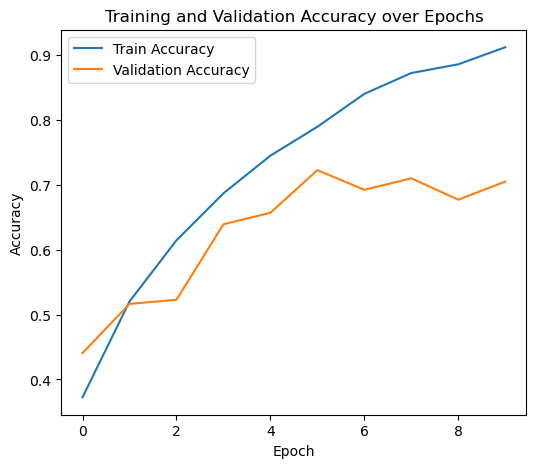

In [5]:
# Plot training and validation accuracy
plt.figure(figsize=(6, 5))
plt.plot(history["train_accuracy"], label="Train Accuracy")
plt.plot(history["val_accuracy"], label="Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.title("Training and Validation Accuracy over Epochs")
plt.show()

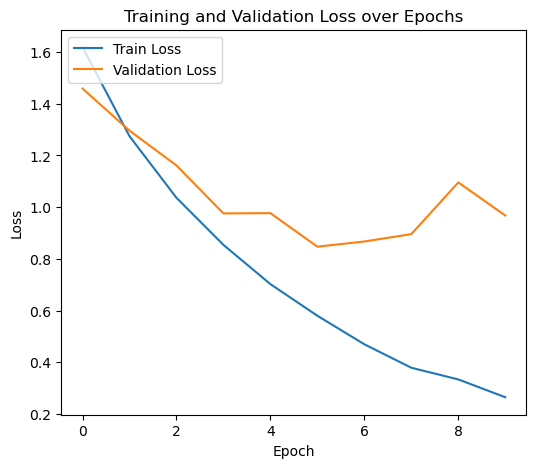

In [6]:
# Plot training and validation loss
plt.figure(figsize=(6, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.title("Training and Validation Loss over Epochs")
plt.show()